## Setup and Preprocessing


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

questions = ["hi", "what is your name", "how are you", "what can you do"]
answers = ["hello", "I am a chatbot", "I'm fine, thank you", "I can help you with your queries"]

answers = ["<sos> " + ans + " <eos>" for ans in answers]

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
    text = text.strip()
    return text

questions = [clean_text(q) for q in questions]
answers = [clean_text(a) for a in answers]

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(questions + answers)

VOCAB_SIZE = len(tokenizer.word_index) + 1

question_seq = tokenizer.texts_to_sequences(questions)
answer_seq = tokenizer.texts_to_sequences(answers)

max_len_q = max(len(seq) for seq in question_seq)
max_len_a = max(len(seq) for seq in answer_seq)

encoder_input = pad_sequences(question_seq, maxlen=max_len_q, padding='post')
decoder_input = pad_sequences([seq[:-1] for seq in answer_seq], maxlen=max_len_a-1, padding='post')
decoder_target = pad_sequences([seq[1:] for seq in answer_seq], maxlen=max_len_a-1, padding='post')


## Encoder-Decoder with LSTM

In [2]:
EMBEDDING_DIM = 64
LSTM_UNITS = 128

encoder_inputs = tf.keras.Input(shape=(max_len_q,))
enc_emb = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(encoder_inputs)
enc_outputs, state_h, state_c = tf.keras.layers.LSTM(LSTM_UNITS, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

decoder_inputs = tf.keras.Input(shape=(max_len_a - 1,))
dec_emb = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(decoder_inputs)
dec_lstm = tf.keras.layers.LSTM(LSTM_UNITS, return_sequences=True, return_state=True)
dec_outputs, _, _ = dec_lstm(dec_emb, initial_state=encoder_states)
dec_dense = tf.keras.layers.Dense(VOCAB_SIZE, activation='softmax')
decoder_outputs = dec_dense(dec_outputs)

model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4, 64)     │      1,536 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 8, 64)     │      1,536 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     98,816 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 8, 128),  │     98,816 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 8, 24)     │      3,096 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 203,800 (796.09 KB)

 Trainable params: 203,800 (796.09 KB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [3]:
decoder_target = np.expand_dims(decoder_target, -1)
model.fit([encoder_input, decoder_input], decoder_target, batch_size=2, epochs=300)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.1042 - loss: 3.1763  
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3542 - loss: 3.1523
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4375 - loss: 3.1166
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3958 - loss: 3.0841
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3958 - loss: 3.0350
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2917 - loss: 2.9933
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4167 - loss: 2.8343
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4167 - loss: 2.6657
Epoch 9/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3958 - loss: 2.4482
Epoch 10/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2708 - loss: 2.4340
Epoch 11/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3542 - loss: 2.1590
Epoch 12/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3958 - 

In [4]:
from tensorflow.keras.utils import plot_model

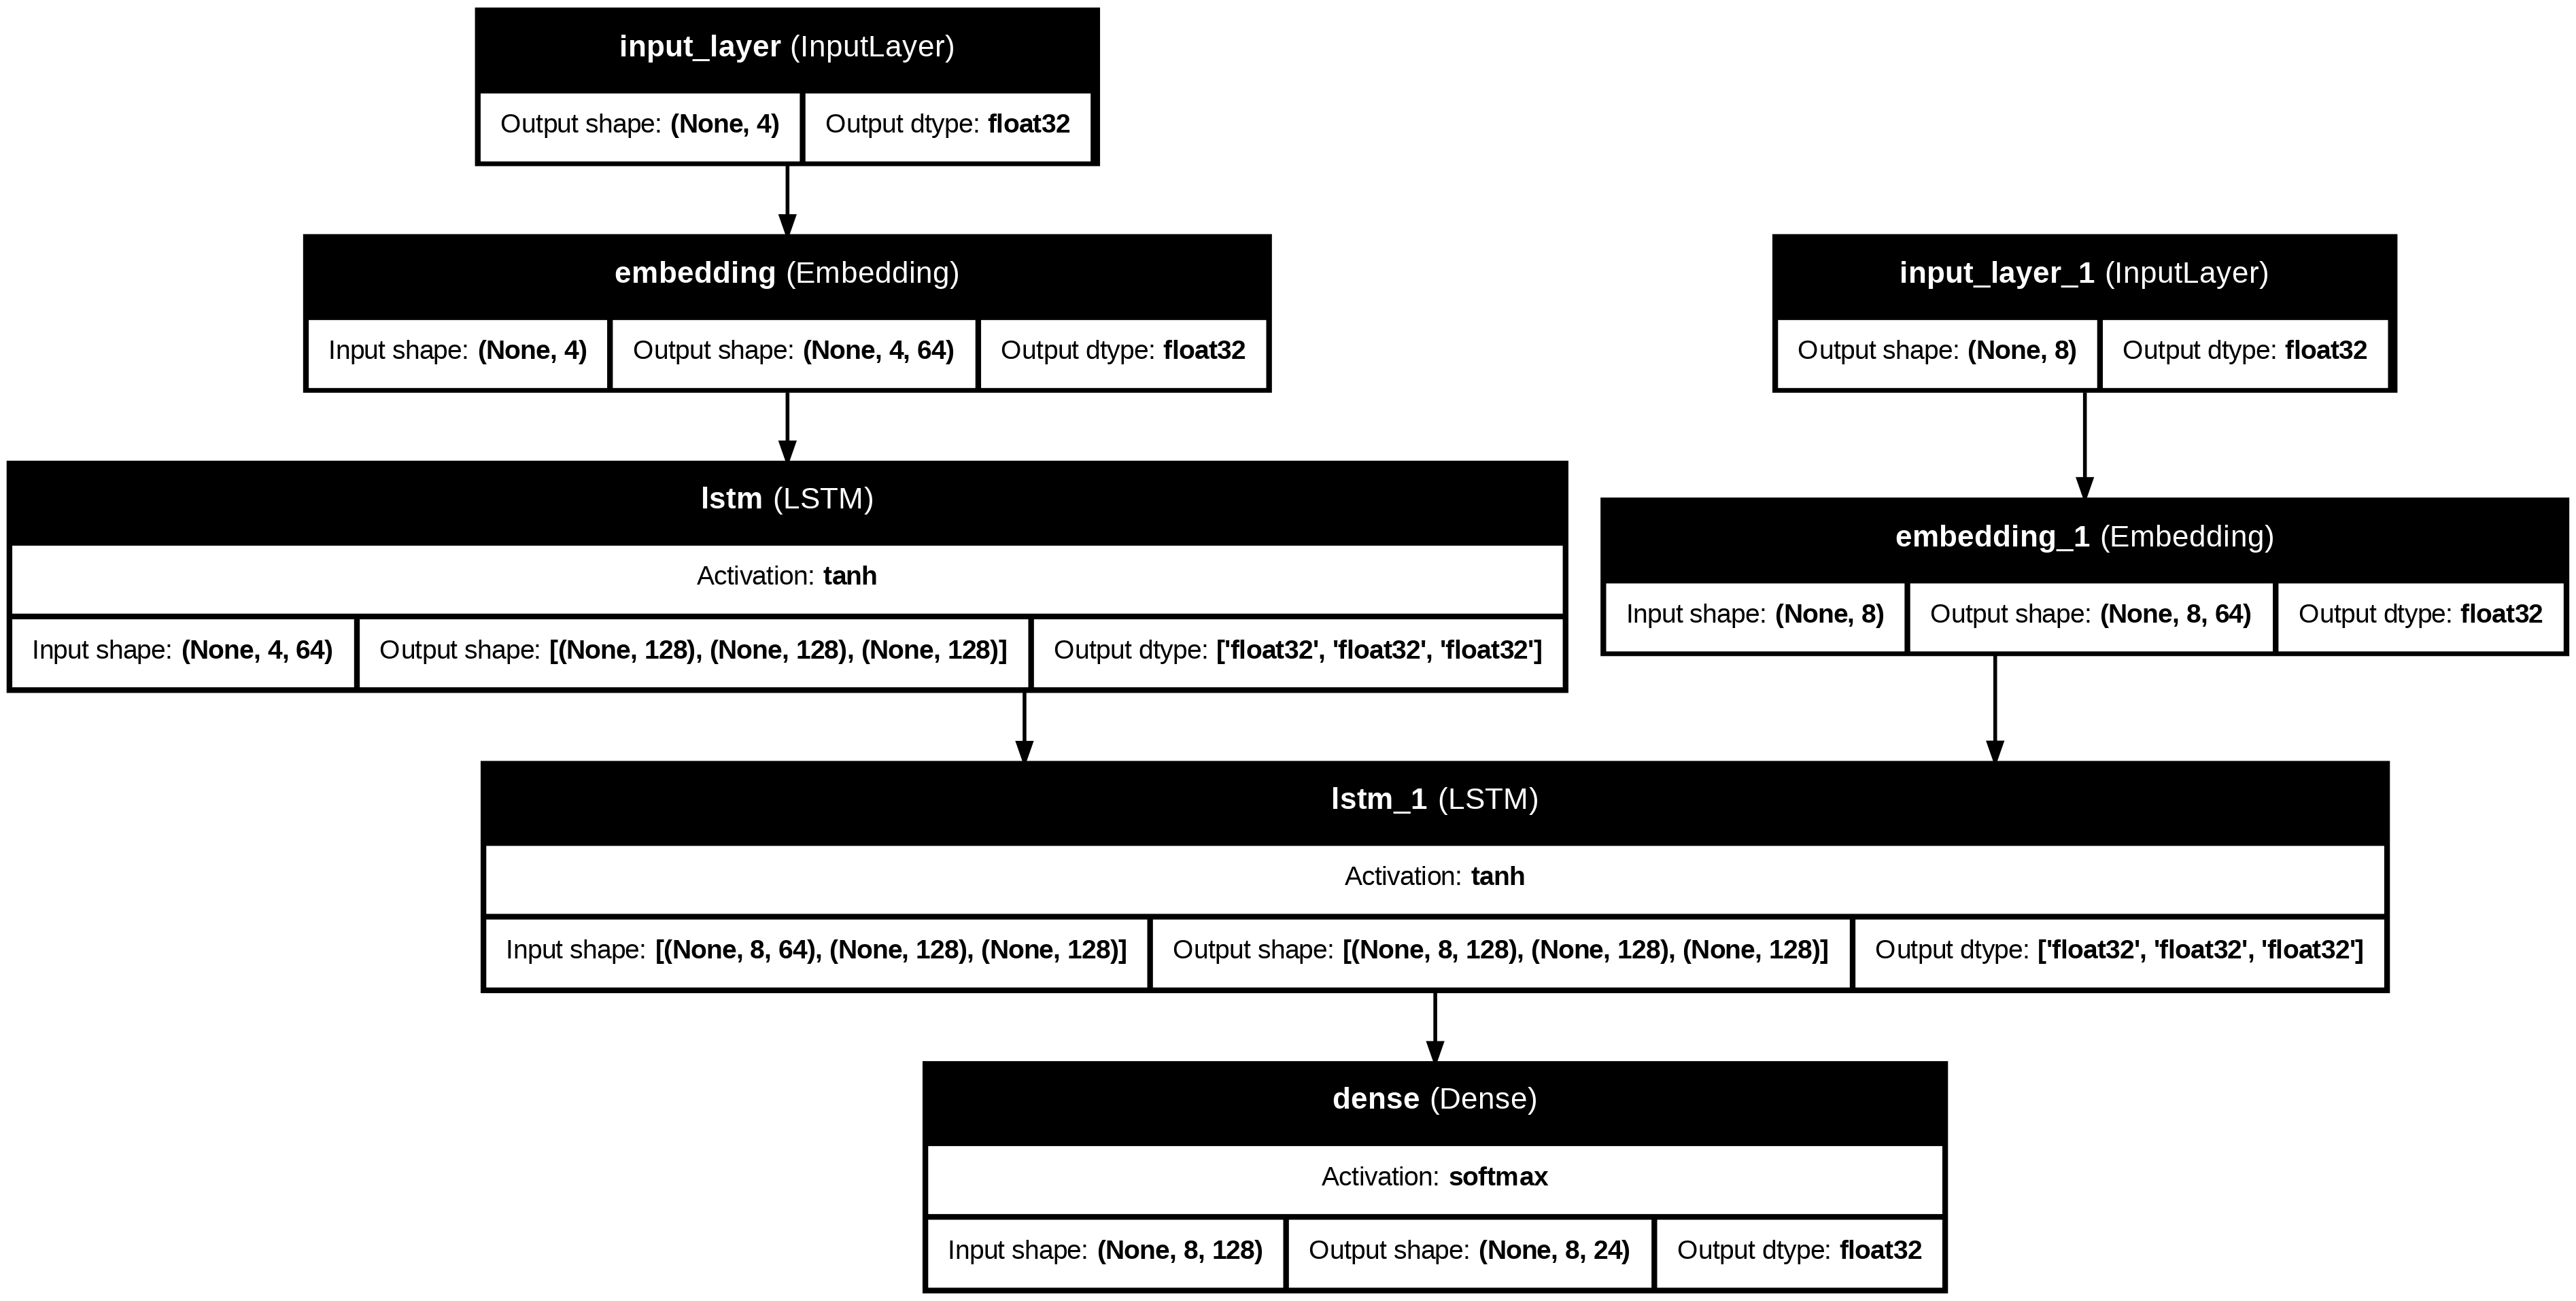

In [5]:
plot_model(model,
           show_shapes =  True,
       show_layer_names = True,
          show_dtype = True,show_layer_activations = True, expand_nested  = True )

## Inference Function

In [ ]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.array([[tokenizer.word_index['<sos>']]])
    stop_condition = False
    decoded_sentence = ""

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '<unk>')

        if sampled_word == '<eos>' or len(decoded_sentence.split()) > max_len_a:
            stop_condition = True
        else:
            decoded_sentence += " " + sampled_word

        target_seq = np.array([[sampled_token_index]])
        states_value = [h, c]

    return decoded_sentence.strip()


## Build encoder/decoder inference models:

In [ ]:
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = tf.keras.Input(shape=(LSTM_UNITS,))
decoder_state_input_c = tf.keras.Input(shape=(LSTM_UNITS,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM)(decoder_inputs)
dec_outputs2, state_h2, state_c2 = dec_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = dec_dense(dec_outputs2)

decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

## Chat Interface (Terminal)

In [ ]:
def chat():
    print("Chatbot is ready! Type 'quit' to stop.")
    while True:
        inp = input("You: ")
        if inp.lower() == 'quit':
            break
        inp = clean_text(inp)
        seq = tokenizer.texts_to_sequences([inp])
        padded = pad_sequences(seq, maxlen=max_len_q, padding='post')
        response = decode_sequence(padded)
        print("Bot:", response)

chat()

Chatbot is ready! Type 'quit' to stop.
